# Photometry FLMM Guide Part II: Testing changes within-trial - cue vs. baseline periods
## Authors: Gabriel Loewinger, Erjia Cui
### 2024-09-07
### rpy2 implementation: Josh Lawrimore

# Part II: Testing changes between two parts of the same trial -- Baseline vs. Cue Period

Sometimes it is desirable to test for changes within-trial. For example, let's say a cue comes on and we want to test whether the average signal changes significantly during the cue-period compared to a pre-cue baseline period. We can test this within the FLMM framework with a simple intercept-only model.

## Data Formating

Let's load the binary data we used in Part I and select the subset of rows corresponding to the CS+. Again for demonstration purpose, we use data taken from Test 4 of [Jeong et al., 2022](https://www.science.org/doi/full/10.1126/science.abq6740) and we thank the authors for generously making their data public and helping us analyze it.

In [6]:
def r2py(mod):
    d = dict(zip(mod.names(), list(mod)))
    return d

def fui2(**kwargs):
    m = fui(**kwargs)
    return r2py(m)

In [1]:
from fast_fmm_rpy2.fmm_run import fui
from fast_fmm_rpy2.plot_fui import plot_fui
from rpy2.robjects import r

r('library(dplyr)')
r(r'dat = read.csv("binary.csv") %>% dplyr::filter(cs == 0)') # CS+ trials only


R callback write-console: 
Attaching package: ‘dplyr’

  
R callback write-console: The following objects are masked from ‘package:stats’:

    filter, lag

  
R callback write-console: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

  
R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
R callback write-console: 
   
R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
R callback write-console: 2:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :  
R callback write-console: 
   
R callback write-console:  library ‘/usr/lib/R/site-library’ contains no packages
  
R callback write-console: 3:   
R callback write-console: In (function (package, help, pos = 2, lib.loc = NULL, 

We will test this question with a functional intercept only model. The functional intercept, as mentioned in Part I, can be interpreted as the mean signal on CS+ trials. Therefore, any time interval where the 95% confidence interval of the functional intercept does not contain 0 (anywhere) can be interpreted as the CS+ trial time intervals where the mean signal is significiantly different from 0.

But what does it mean for the signal to be significantly different from 0? This depends entirely on how the data is pre-processed. If each trial’s signal is, for example, normalized to a trial-specific baseline, the interpretation of the hypothesis test will be with reference to how 0 is defined in each trial. For example, if we calculate the average signal during the pre-cue period (-2 sec to 0 sec) as a trial-specific baseline, and then subtract that off of every timepoint, then the value 0 is “re-defined” to be the average during the pre-cue period. Thus, significant deviations during the cue-period should be interepreted as significant differences from a trial-level baseline period average. This pre-processing choices can change the results and interpretation, so it is important to carefully describe these choices when results are written up. Let’s take the above approach of subtracting the trial-specific pre-cue baseline period average from each signal value.

In [2]:
# normalize to pre-cue baseline period
r('baseline_photometry = paste0("photometry.", 1:50)') # names of photometry columns during first 2 sec
r('full_photometry = paste0("photometry.", 1:125)') # names of all photometry columns
r('dat[,full_photometry] = dat[,full_photometry] - rowMeans(dat[,baseline_photometry])') # subtract off trial-specific baseline from each photometry value
r_dat = r('dat')


To get the basic idea, let's proceed with an intercept only model with an animal-specific random intercept. As usual, we set `parallel=TRUE` to speed up the code.

Model 1:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid  \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s)  \notag 
\end{aligned} 
$$ 

In [7]:
# fit model
mod = fui2(csv_filepath=None, formula='photometry ~ 1 + (1 | id)', parallel=False, r_var_name='dat') # random intercepts model


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


We could have fit more complicated models if we wanted to by, for example, adjusting for baseline covariates (e.g., age, sex) or trial/session number. This changes the interpretation, but may be appropriate in some contexts. We will discuss more complicated models in subsequent vignettes.

Let’s plot the output.

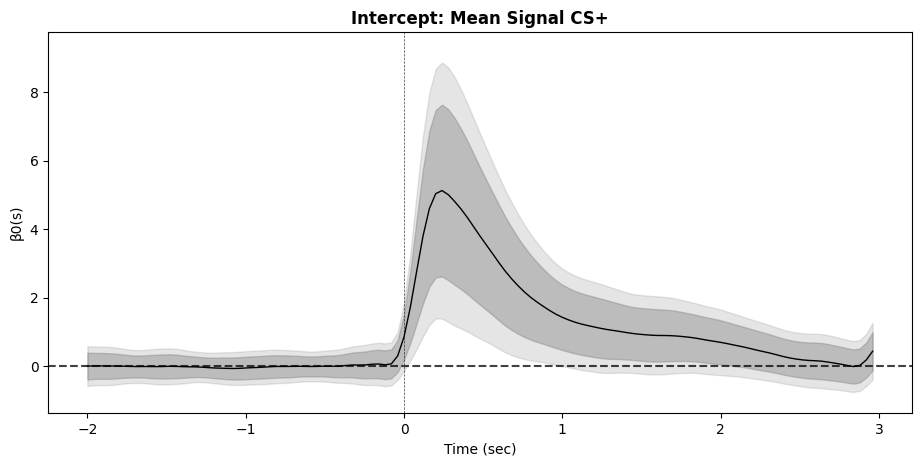

In [8]:
# plot model with best model fit (AIC/BIC)
figure = plot_fui(mod, 
         xlab = "Time (sec)", # label x-axis
         x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
         align_x = 2, # align to time of cue onset
         title_names = ["Intercept: Mean Signal CS+"]
         )
figure.set_size_inches(10, 5)


# Pointwise or Joint 95% Confidence Intervals
We recommend basing inference off of joint CIs for two reasons: interpretability and multiple comparisons corrections. Joint CIs identify $intervals$ of the trial during which the effects are significant, while pointwise identify individual timepoints that are significant. Typically analyst are more interested in time intervals and so we argue joint CIs are more interpretable in photometry analyses. Joint CIs also provide an adjustment for the multiple comparisons of inspecting effects along the entire trial. It is reasonable to report both types of CIs, but we recommend basing conclusions off of joint CIs in most situations.

# How to Cite
For use of this package or vignette, please cite the following papers:

Gabriel Loewinger, Erjia Cui, David Lovinger, and Francisco Pereiera. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://elifesciences.org/reviewed-preprints/95802). eLife (2024).

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

# References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Huijeong Jeong, Annie Taylor, Joseph Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis Burke, Vijay Namboodiri. [Mesolimbic dopamine release conveys causal associations.](https://www.science.org/doi/full/10.1126/science.abq6740) Science 378, 6740 (2022).